In [1]:
import pandas as pd
import numpy as np

from numpy.linalg import lstsq
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from numba import njit

In [2]:
G = 3

In [3]:
from linearmodels.datasets import wage_panel
wage_panel_df = wage_panel.load()

wage_panel_df.set_index(['nr', 'year'], inplace=True)
y = wage_panel_df['lwage']
x = wage_panel_df.drop(columns=["occupation", "lwage", "black", "hisp", "educ"])
display(x)
display(y)

exper  hours  married  union  expersq
nr    year                                       
13    1980      1   2672        0      0        1
      1981      2   2320        0      1        4
      1982      3   2940        0      0        9
      1983      4   2960        0      0       16
      1984      5   3071        0      0       25
...           ...    ...      ...    ...      ...
12548 1983      8   2080        1      0       64
      1984      9   2080        1      1       81
      1985     10   2080        1      0      100
      1986     11   2080        1      1      121
      1987     12   3380        1      1      144

[4360 rows x 5 columns]

nr     year
13     1980    1.197540
       1981    1.853060
       1982    1.344462
       1983    1.433213
       1984    1.568125
                 ...   
12548  1983    1.591879
       1984    1.212543
       1985    1.765962
       1986    1.745894
       1987    1.466543
Name: lwage, Length: 4360, dtype: float64

In [4]:
N = x.index.get_level_values(0).nunique()
T = x.index.get_level_values(1).nunique()
K = x.shape[1]
N, T, K

(545, 8, 5)

In [5]:
x = x.values.reshape(N, T, K)
y = y.values.reshape(N, T, 1)
x, y

(array([[[   1, 2672,    0,    0,    1],
         [   2, 2320,    0,    1,    4],
         [   3, 2940,    0,    0,    9],
         ...,
         [   6, 2864,    0,    0,   36],
         [   7, 2994,    0,    0,   49],
         [   8, 2640,    0,    0,   64]],
 
        [[   4, 2484,    0,    0,   16],
         [   5, 2804,    0,    0,   25],
         [   6, 2530,    0,    0,   36],
         ...,
         [   9, 2164,    0,    0,   81],
         [  10, 2749,    0,    0,  100],
         [  11, 2476,    0,    0,  121]],
 
        [[   4, 2332,    1,    0,   16],
         [   5, 2116,    1,    0,   25],
         [   6, 2500,    1,    0,   36],
         ...,
         [   9, 2340,    1,    0,   81],
         [  10, 2340,    1,    0,  100],
         [  11, 2340,    1,    0,  121]],
 
        ...,
 
        [[   4, 2008,    1,    0,   16],
         [   5, 3190,    0,    0,   25],
         [   6, 2584,    0,    0,   36],
         ...,
         [   9, 2290,    1,    0,   81],
         [  10, 31

In [6]:
# @njit
def _get_starting_values(y, x, G: int, N: int, K: int):
    """Generates the starting values of theta"""
    num_start_vars: int = K + G # FIXME I believe that shape is slow in Cython
    random_draws_theta = np.random.choice(N, num_start_vars, replace=False)
    x_stack_start = x[random_draws_theta].reshape(-1, K)
    y_stack_start = y[random_draws_theta].reshape(-1, 1)

    # FIXME some errors may arise, maybe add some checks
    theta_init = lstsq(x_stack_start, y_stack_start, rcond=None)[0]

    random_draws_alpha = np.random.choice(N, size=G, replace=False)
    alpha_init = np.squeeze(y[random_draws_alpha] - x[random_draws_alpha, :, :] @ theta_init)

    return theta_init, alpha_init

@njit
def _compute_groupings(res, alpha):
    """Computes the groupings based on the residuals and alpha"""
    euclidean_distance_between_grouping = ((res[None, :, :] - alpha[:, None, :]) ** 2).sum(axis=2)
    g = np.argmin(euclidean_distance_between_grouping, axis=0)  # Closest group
    return g

# @njit
def _compute_alpha(res, g, G):
    """Computes the alpha values based on the residuals and groupings"""
    counts = np.bincount(g, minlength=G)[:, None]  # (G, 1) — number of elements in each group
    sums = np.zeros((G, res.shape[1]))  # (G, K) — sum of residuals per group
    np.add.at(sums, g, res)  # sums[i] += res[j] for all j where g[j] == i
    alpha = sums / counts  # mean = sum / count
    return alpha

# @njit
def _compute_theta(x, y, alpha, g):
    """Computes the theta values based on the x, y, alpha and groupings"""
    # FIXME check if this makes sense
    K = x.shape[2] # FIXME I believe that shape is slow in Cython
    theta = lstsq(x.reshape(-1, K), y.reshape(-1, 1) - alpha[g].reshape(-1, 1), rcond=None)[0]
    return theta

# @njit
def _compute_residuals(y, x, theta):
    """Computes the residuals based on y, x and theta"""
    res = np.squeeze(y - x @ theta)
    return res

# @njit
def _compute_objective_value(res, alpha, g):
    """Computes the objective value based on the residuals, alpha and groupings"""
    # print(f"res: {res}")
    # print(f"alpha: {alpha}")
    # display(f"g: {g}")
    # display(f"alpha[g]: {alpha[g]}")
    objective_value = ((res - alpha[g])**2).sum()
    return objective_value

def _reorder_groups(g, alpha):
    """Reorders the groups based on the first value of alpha"""
    # FIXME this is not the best way to do this
    # But it works for now
    mapping = np.argsort(alpha[:, 0])
    ordered_g = np.argsort(mapping)[g]
    ordered_alpha = alpha[mapping]
    return ordered_g, ordered_alpha

def _grouped_fixed_effects_iteration(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values(y, x, G, N, K)
    res = _compute_residuals(y, x, theta)
    g = _compute_groupings(res, alpha)

    objective_value = np.inf

    iterations_used = 0
    for i in range(max_iter):
        alpha = _compute_alpha(res, g, G)
        theta = _compute_theta(x, y, alpha, g)
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        g = _compute_groupings(res, alpha)
        new_objective_value = _compute_objective_value(res, alpha, g)


        if abs(objective_value - new_objective_value) < tol:
            iterations_used = i
            objective_value = new_objective_value
            break

        objective_value = new_objective_value

    return theta, alpha, g, iterations_used, objective_value

def _compute_eta(y_bar, x_bar, theta):
    """Computes the eta values based on y_bar, x_bar and theta"""
    eta = np.squeeze(y_bar - x_bar @ theta)
    return eta

# FIXME not used right now but still neccesary
def _compute_statistics(objective_value, N, T, K, G):
    """Computes the statistics based on the objective value, N, T, K and G"""
    # FIXME this is not the best way to do this
    # But it works for now
    sigma_squared = 1 / (N * T - G * T - N - K) * objective_value
    BIC = 1/(N*T) * objective_value + sigma_squared * (G * T + N + K) / (N * T)
    return sigma_squared, BIC


def grouped_fixed_effects(y, x, G, max_iter=10000, tol=1e-8, gfe_iterations=20, unit_specific_effects=False):
    """
    Computes the grouped fixed effects using the algorithm described in the paper.
    """
    # FIXME not really required if unit_specific_effects is False
    # But this seems like the easiest implementation
    x_bar = np.mean(x, axis=1, keepdims=True)
    y_bar = np.mean(y, axis=1, keepdims=True)

    best_theta = None
    best_alpha = None
    best_g = None
    best_iterations_used = None
    best_objective_value = np.inf

    N = x.shape[0]
    K = x.shape[2]

    # FIXME this code does not drop constant binary variables by itself
    # The input class should be able to do this
    if unit_specific_effects:
        # Demean x and y
        x = x - x_bar
        y = y - y_bar

    for _ in range(gfe_iterations):
        theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration(
            y,
            x,
            G,
            N,
            K,
            max_iter,
            tol,
        )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_theta = theta
            best_g, best_alpha = _reorder_groups(g, alpha)
            # best_g, best_alpha = g, alpha
            best_iterations_used = iterations_used

    if unit_specific_effects:
        eta = _compute_eta(y_bar, x_bar, best_theta)
        return best_theta, best_alpha, best_g, eta, best_iterations_used, best_objective_value

    # NOTE None is for lack of unit specific effects
    return best_theta, best_alpha, best_g, None, best_iterations_used, best_objective_value


# FIXME Somewhere I have assumed that the sum of alpha is 0, this however does not have to be the case
# I however do not know where and it may be for the computation of eta, in which case it is not a problem.
grouped_fixed_effects(y[:30], x[:30], 3, max_iter=10000, tol=1e-8, gfe_iterations=100, unit_specific_effects=False)

(array([[ 1.91338746e-01],
        [-1.00614107e-05],
        [-4.50946172e-02],
        [ 1.36975666e-02],
        [-1.20786672e-02]]),
 array([[ 0.77157942,  0.97220149,  0.60774169,  0.74205585,  0.45468941,
          0.41445034, -0.55124152,  0.21989449],
        [ 0.99903001,  0.89740085,  0.92755698,  0.84349921,  0.85244106,
          0.96691788,  1.01739487,  1.20787093],
        [ 1.36803748,  1.50129163,  1.42087257,  1.52766607,  1.53995778,
          1.57303701,  1.57360275,  1.8048568 ]]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 0, 2]),
 None,
 1141,
 np.float64(20.188454271260603))

In [7]:
# @njit
def _get_starting_values(y, x, G: int, N: int, K: int):
    """Generates the starting values of theta"""
    num_start_vars: int = x.shape[1] + G  # FIXME I believe that shape is slow in Cython
    random_draws_theta = np.random.choice(N, num_start_vars, replace=False)
    x_stack_start = x[random_draws_theta].reshape(-1, K)
    y_stack_start = y[random_draws_theta].reshape(-1, 1)

    # FIXME some errors may arise, maybe add some checks
    theta_init = lstsq(x_stack_start, y_stack_start, rcond=None)[0]

    random_draws_alpha = np.random.choice(N, size=G, replace=False)
    alpha_init = np.squeeze(y[random_draws_alpha] - x[random_draws_alpha, :, :] @ theta_init)

    return theta_init, alpha_init


@njit
def _compute_groupings(res, alpha):
    """Computes the groupings based on the residuals and alpha"""
    euclidean_distance_between_grouping = ((res[None, :, :] - alpha[:, None, :]) ** 2).sum(axis=2)
    g = np.argmin(euclidean_distance_between_grouping, axis=0)  # Closest group
    return g


# @njit
def _compute_alpha(res, g, G):
    """Computes the alpha values based on the residuals and groupings"""
    counts = np.bincount(g, minlength=G)[:, None]  # (G, 1) — number of elements in each group
    sums = np.zeros((G, res.shape[1]))  # (G, K) — sum of residuals per group
    np.add.at(sums, g, res)  # sums[i] += res[j] for all j where g[j] == i
    alpha = sums / counts  # mean = sum / count
    return alpha


# @njit
def _compute_theta(x, y, alpha, g):
    """Computes the theta values based on the x, y, alpha and groupings"""
    # FIXME check if this makes sense
    K = x.shape[2]  # FIXME I believe that shape is slow in Cython
    theta = lstsq(x.reshape(-1, K), y.reshape(-1, 1) - alpha[g].reshape(-1, 1), rcond=None)[0]
    return theta


# @njit
def _compute_residuals(y, x, theta):
    """Computes the residuals based on y, x and theta"""
    res = np.squeeze(y - x @ theta)
    return res


@njit
def _compute_objective_value(res, alpha, g):
    """Computes the objective value based on the residuals, alpha and groupings"""
    objective_value = ((res - alpha[g]) ** 2).sum()
    return objective_value


def _reorder_groups(g, alpha):
    """Reorders the groups based on the first value of alpha"""
    # FIXME this is not the best way to do this
    # But it works for now
    mapping = np.argsort(alpha[:, 0])
    ordered_g = np.argsort(mapping)[g]
    ordered_alpha = alpha[mapping]
    return ordered_g, ordered_alpha

def _hkmeans(y, x, theta, alpha, g, G, max_iter=1000, tol=1e-6):
    objective_value = np.inf

    for i in range(max_iter):
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        theta = _compute_theta(x, y, alpha, g)
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        g = _compute_groupings(res, alpha)
        alpha = _compute_alpha(res, g, G)
        new_objective_value = _compute_objective_value(res, alpha, g)

        if abs(objective_value - new_objective_value) < tol:
            return theta, alpha, g, i, new_objective_value

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _run_vns(y, x, g, G, N, alpha, theta, init_objective_value, max_vns_iter=10, tol=1e-8, max_alg1_iter=20):
    # FIXME this is not the best way to do this
    # But it works for now
    best_objective_value = init_objective_value
    objective_value = np.inf
    g = g.copy()


    i = 1
    while i <= max_vns_iter:
        # Randomly change a few groupings
        g_new = g.copy()

        # FIXME this should check if there are empty groups
        g_new[np.random.choice(N, size=i, replace=False)] = np.random.choice(G, size=i, replace=True)

        # Apply algorithm 1
        theta_new, alpha_new, g_new, iterations_used, objective_value = _hkmeans(y, x, theta, alpha, g_new, G)

        # Local 1 step search
        changed = True
        while changed:
            changed = False
            for j in range(N):
                for k in range(G):
                    if g_new[j] == k:
                        continue

                    # FIXME add check to not leave any group empty

                    g_local = g_new.copy()
                    g_local[j] = k

                    # FIXME this may be very slow
                    if (np.bincount(g_local, minlength=G)==0).any():
                        continue

                    theta_local, alpha_local, g_local, iterations_used, objective_value_local = _hkmeans(y, x, theta_new, alpha_new, g_local, G, max_alg1_iter)

                    if objective_value_local < objective_value:
                        g_new = g_local
                        theta_new = theta_local
                        alpha_new = alpha_local
                        objective_value = objective_value_local
                        changed = True
                        # print(f"Changed group {j} to {k} in iteration {i} with objective value {objective_value}")

        if objective_value < best_objective_value:
            g = g_new
            theta = theta_new
            alpha = alpha_new
            best_objective_value = objective_value
            i = 1

        else:
            i+= 1

    return g, theta, alpha, objective_value


def _grouped_fixed_effects_iteration_vns(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8, neighbor_max=10):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values(y, x, G, N, K)
    res = _compute_residuals(y, x, theta)
    g = _compute_groupings(res, alpha)

    objective_value = np.inf

    for i in range(max_iter):
        alpha = _compute_alpha(res, g, G)
        theta = _compute_theta(x, y, alpha, g)
        res = _compute_residuals(y, x, theta)
        alpha = _compute_alpha(res, g, G)
        g = _compute_groupings(res, alpha)
        alpha = _compute_alpha(res, g, G)
        new_objective_value = _compute_objective_value(res, alpha, g)

        # TODO run VNS
        g, theta, alpha, new_objective_value = _run_vns(y, x, g, G, N, alpha, theta, new_objective_value)

        # if abs(objective_value - new_objective_value) < tol:
        #     iterations_used = i
        #     objective_value = new_objective_value
        #     break

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _compute_eta(y_bar, x_bar, theta):
    """Computes the eta values based on y_bar, x_bar and theta"""
    eta = np.squeeze(y_bar - x_bar @ theta)
    return eta


# FIXME not used right now but still neccesary
def _compute_statistics(objective_value, N, T, K, G):
    """Computes the statistics based on the objective value, N, T, K and G"""
    # FIXME this is not the best way to do this
    # But it works for now
    sigma_squared = 1 / (N * T - G * T - N - K) * objective_value
    BIC = 1 / (N * T) * objective_value + sigma_squared * (G * T + N + K) / (N * T)
    return sigma_squared, BIC


def grouped_fixed_effects(
    y, x, G, max_iter=10000, tol=1e-8, gfe_iterations=20, unit_specific_effects=False, enable_vns=True
):
    """
    Computes the grouped fixed effects using the algorithm described in the paper.
    """
    # FIXME not really required if unit_specific_effects is False
    # But this seems like the easiest implementation
    x_bar = np.mean(x, axis=1, keepdims=True)
    y_bar = np.mean(y, axis=1, keepdims=True)

    best_theta = None
    best_alpha = None
    best_g = None
    best_iterations_used = None
    best_objective_value = np.inf

    N = x.shape[0]
    K = x.shape[2]

    # FIXME this code does not drop constant binary variables by itself
    # The input class should be able to do this
    if unit_specific_effects:
        # Demean x and y
        x = x - x_bar
        y = y - y_bar

    for _ in range(gfe_iterations):
        if enable_vns:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_vns(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )
        else:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_theta = theta
            best_g, best_alpha = _reorder_groups(g, alpha)
            # best_g, best_alpha = g, alpha
            best_iterations_used = iterations_used

    if unit_specific_effects:
        eta = _compute_eta(y_bar, x_bar, best_theta)
        return best_theta, best_alpha, best_g, eta, best_iterations_used, best_objective_value

    # NOTE None is for lack of unit specific effects
    return best_theta, best_alpha, best_g, None, best_iterations_used, best_objective_value

# FIXME tolerance is not relevant for VNS
grouped_fixed_effects(y[0:30], x[0:30], 3, max_iter=50, tol=1e-8, gfe_iterations=1, unit_specific_effects=False, enable_vns=True)

(array([[ 1.91129281e-01],
        [-1.00858932e-05],
        [-4.50647218e-02],
        [ 1.36772421e-02],
        [-1.20633347e-02]]),
 array([[ 0.77194151,  0.97271052,  0.6083636 ,  0.74275199,  0.45545412,
          0.41523498, -0.55046292,  0.22064667],
        [ 0.99952481,  0.89800845,  0.92823579,  0.84422999,  0.85319092,
          0.96765786,  1.01809916,  1.20849468],
        [ 1.36854498,  1.50190293,  1.42156251,  1.52838904,  1.54068949,
          1.57374721,  1.57426434,  1.80544331]]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 0, 2]),
 None,
 50,
 20.188454248864787)

In [8]:
# A practical rule of thumb for choosing the tuning parameters is to check that different starting values tend to yield the exact same solution. (from the paper)
# grouped_fixed_effects(y[0:60], x[0:60], 3, max_iter=10000, tol=1e-8, gfe_iterations=100)
grouped_fixed_effects(
    y[0:30], x[0:30], 3, max_iter=10, tol=1e-8, gfe_iterations=1, unit_specific_effects=False, enable_vns=True
)

(array([[ 1.91202339e-01],
        [-1.00816544e-05],
        [-4.50730178e-02],
        [ 1.36837455e-02],
        [-1.20690198e-02]]),
 array([[ 0.77182659,  0.9725455 ,  0.60816244,  0.74252643,  0.45521122,
          0.41498921, -0.550701  ,  0.22042487],
        [ 0.99936324,  0.89781016,  0.92801465,  0.84399499,  0.852954  ,
          0.9674299 ,  1.0178905 ,  1.20831954],
        [ 1.36837988,  1.50170428,  1.42133997,  1.52815785,  1.54045941,
          1.57352953,  1.57406956,  1.8052813 ]]),
 array([0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 1, 1, 2, 1, 0, 2]),
 None,
 10,
 20.188454296096243)

## Attempt at implementing Extension 2

In [9]:
# @njit
# FIXME remove this variable
def _get_starting_values_hetrogeneous(y, x, G: int, N: int, K: int):
    """Generates the starting values of theta"""
    num_start_vars: int = x.shape[1] + G  # FIXME I believe that shape is slow in Cython
    random_draws_theta = np.random.choice(N, num_start_vars, replace=False)
    x_stack_start = x[random_draws_theta].reshape(-1, K)
    y_stack_start = y[random_draws_theta].reshape(-1, 1)

    # FIXME some errors may arise, maybe add some checks
    theta_init = lstsq(x_stack_start, y_stack_start, rcond=None)[0]

    random_draws_alpha = np.random.choice(N, size=G, replace=False)
    alpha_init = np.squeeze(y[random_draws_alpha] - x[random_draws_alpha, :, :] @ theta_init)

    # FIXME this should be changed such that
    return np.tile(theta_init, (1, G)), alpha_init

# TODO create function for hetrogeneous theta


# @njit
def _compute_groupings_hetrogeneous(res, alpha):
    """Computes the groupings based on the residuals and alpha"""
    euclidean_distance_between_grouping = np.squeeze((res - alpha.T[None, :, :]) ** 2).sum(axis=1)
    g = np.argmin(euclidean_distance_between_grouping, axis=1)  # Closest group
    return g


# # @njit
def _compute_alpha_hetrogeneous(res, g, G):
    """Computes the alpha values based on the residuals and groupings"""
    n, T, _ = res.shape
    counts = np.bincount(g, minlength=G)  # shape: (G,)
    R = res[np.arange(n), :, g]  # shape: (n, T)
    sums = np.zeros((G, T))
    np.add.at(sums, g, R)  # sums[k] += R[i] whenever g[i]==k
    alphas = sums / counts[:, None]  # broadcast counts over T
    return alphas


# # @njit
def _compute_theta_hetrogeneous(x, y, alpha, g, G, K):
    """Computes the theta values based on the x, y, alpha and groupings"""
    # FIXME check if this makes sense
    theta = np.zeros((K, G))
    for i in range(G):
        theta[:, i] = lstsq(x[g==i].reshape(-1, K), np.squeeze((np.squeeze(y[g == i]) - alpha[i]).reshape(-1, 1)), rcond=None)[0]

    return theta


# # @njit
def _compute_residuals_hetrogeneous(y, x, theta, G):
    """Computes the residuals based on y, x and theta"""
    res = np.tile(y, (1, G)) - x @ theta
    return res


@njit
def _compute_objective_value_hetrogeneous(res, alpha, g, N):
    """Computes the objective value based on the residuals, alpha and groupings"""
    s = 0
    for i in range(N):
        s += ((res[i,:,g[i]] - alpha[g[i]]) ** 2).sum()

    return s


def _reorder_groups_hetrogeneous(g, alpha, theta, hetrogeneous_theta):
    """Reorders the groups based on the first value of alpha"""
    # FIXME this is not the best way to do this
    # But it works for now
    mapping = np.argsort(alpha[:, 0])
    ordered_g = np.argsort(mapping)[g]
    ordered_alpha = alpha[mapping]
    if not hetrogeneous_theta:
        return ordered_g, ordered_alpha, theta
    ordered_theta = theta[:, mapping]
    return ordered_g, ordered_alpha, ordered_theta


def _hkmeans_hetrogeneous(y, x, theta, alpha, g, G, K, N, max_iter=1000, tol=1e-6):
    objective_value = np.inf

    for i in range(max_iter):
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        theta = _compute_theta_hetrogeneous(x, y, alpha, g, G, K)
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        g = _compute_groupings_hetrogeneous(res, alpha)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        new_objective_value = _compute_objective_value_hetrogeneous(res, alpha, g, N)

        if abs(objective_value - new_objective_value) < tol:
            return theta, alpha, g, i, new_objective_value

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _run_vns_hetrogeneous(y, x, g, G, N, alpha, theta, init_objective_value, K, max_vns_iter=10, tol=1e-8, max_alg1_iter=20):
    # FIXME this is not the best way to do this
    # But it works for now
    best_objective_value = init_objective_value
    objective_value = np.inf
    g = g.copy()

    i = 1
    while i <= max_vns_iter:
        print(f"vns iter: {i}")
        # Randomly change a few groupings
        g_new = g.copy()

        # FIXME this should check if there are empty groups
        g_new[np.random.choice(N, size=i, replace=False)] = np.random.choice(G, size=i, replace=True)

        # Apply algorithm 1
        theta_new, alpha_new, g_new, iterations_used, objective_value = _hkmeans_hetrogeneous(
            y, x, theta, alpha, g_new, G, K, N
        )

        # Local 1 step search
        changed = True
        while changed:
            changed = False
            for j in range(N):
                for k in range(G):
                    if g_new[j] == k:
                        continue

                    # FIXME add check to not leave any group empty

                    g_local = g_new.copy()
                    g_local[j] = k

                    # FIXME this may be very slow
                    if (np.bincount(g_local, minlength=G) == 0).any():
                        continue

                    theta_local, alpha_local, g_local, iterations_used, objective_value_local = _hkmeans_hetrogeneous(
                        y, x, theta_new, alpha_new, g_local, G, K, N, max_alg1_iter
                    )

                    if objective_value_local < objective_value:
                        g_new = g_local
                        theta_new = theta_local
                        alpha_new = alpha_local
                        objective_value = objective_value_local
                        changed = True
                        # print(f"Changed group {j} to {k} in iteration {i} with objective value {objective_value}")

        if objective_value < best_objective_value:
            g = g_new
            theta = theta_new
            alpha = alpha_new
            best_objective_value = objective_value
            i = 1
            print(f"Succes at iteration {i} with objective value {best_objective_value}")

        else:
            i += 1

    return g, theta, alpha, objective_value


def _grouped_fixed_effects_iteration_vns_hetrogeneous(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8, neighbor_max=10):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values_hetrogeneous(y, x, G, N, K)
    res = _compute_residuals_hetrogeneous(y, x, theta, G)
    g = _compute_groupings_hetrogeneous(res, alpha)

    objective_value = np.inf

    for i in range(max_iter):
        print(f"ITERATION: {i}")
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        theta = _compute_theta_hetrogeneous(x, y, alpha, g, G, K)
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        g = _compute_groupings_hetrogeneous(res, alpha)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        new_objective_value = _compute_objective_value_hetrogeneous(res, alpha, g, N)

        # TODO run VNS
        g, theta, alpha, new_objective_value = _run_vns_hetrogeneous(y, x, g, G, N, alpha, theta, new_objective_value, K)

        # if abs(objective_value - new_objective_value) < tol:
        #     iterations_used = i
        #     objective_value = new_objective_value
        #     break

        objective_value = new_objective_value

    return theta, alpha, g, max_iter, objective_value


def _grouped_fixed_effects_iteration_hetrogeneous(y, x, G: int, N: int, K: int, max_iter=10000, tol=1e-8):
    # FIXME possibly create some sort of array that stores these values
    # Could be used for debugging
    theta, alpha = _get_starting_values_hetrogeneous(y, x, G, N, K)
    res = _compute_residuals_hetrogeneous(y, x, theta, G)
    g = _compute_groupings_hetrogeneous(res, alpha)

    objective_value = np.inf

    iterations_used = 0
    for i in range(max_iter):
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        theta = _compute_theta_hetrogeneous(x, y, alpha, g, G, K)
        res = _compute_residuals_hetrogeneous(y, x, theta, G)
        alpha = _compute_alpha_hetrogeneous(res, g, G)
        g = _compute_groupings_hetrogeneous(res, alpha)
        new_objective_value = _compute_objective_value_hetrogeneous(res, alpha, g, N)

        if abs(objective_value - new_objective_value) < tol:
            objective_value = new_objective_value
            break

        objective_value = new_objective_value
        iterations_used = i

    return theta, alpha, g, iterations_used, objective_value


def _compute_eta_hetrogeneous(y_bar, x_bar, theta):
    """Computes the eta values based on y_bar, x_bar and theta"""
    eta = np.squeeze(y_bar - x_bar @ theta.mean(axis=1))
    return eta


# # FIXME not used right now but still neccesary
# def _compute_statistics(objective_value, N, T, K, G):
#     """Computes the statistics based on the objective value, N, T, K and G"""
#     # FIXME this is not the best way to do this
#     # But it works for now
#     sigma_squared = 1 / (N * T - G * T - N - K) * objective_value
#     BIC = 1 / (N * T) * objective_value + sigma_squared * (G * T + N + K) / (N * T)
#     return sigma_squared, BIC


def grouped_fixed_effects(
    y, x, G, max_iter=10000, tol=1e-8, gfe_iterations=20, unit_specific_effects=False, enable_vns=True, hetrogeneous_theta=False
):
    """
    Computes the grouped fixed effects using the algorithm described in the paper.
    """
    # FIXME not really required if unit_specific_effects is False
    # But this seems like the easiest implementation
    x_bar = np.mean(x, axis=1, keepdims=True)
    y_bar = np.mean(y, axis=1, keepdims=True)

    best_theta = None
    best_alpha = None
    best_g = None
    best_iterations_used = None
    best_objective_value = np.inf

    N = x.shape[0]
    T = x.shape[1]
    K = x.shape[2]

    # FIXME this code does not drop constant binary variables by itself
    # The input class should be able to do this
    if unit_specific_effects:
        # Demean x and y
        x = x - x_bar
        y = y - y_bar

    for _ in range(gfe_iterations):
        # FIXME should be better way to do this
        if hetrogeneous_theta and enable_vns:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_vns_hetrogeneous(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )
        elif enable_vns:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_vns(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )

        elif hetrogeneous_theta:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration_hetrogeneous(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol,
            )

        else:
            theta, alpha, g, iterations_used, objective_value = _grouped_fixed_effects_iteration(
                y,
                x,
                G,
                N,
                K,
                max_iter,
                tol
            )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_g, best_alpha, best_theta = _reorder_groups_hetrogeneous(g, alpha, theta, hetrogeneous_theta)
            # best_g, best_alpha = g, alpha
            best_iterations_used = iterations_used

    # FIXME this should not be true for hetrogeneous theta
    # Because does not work
    if unit_specific_effects:
        eta = _compute_eta_hetrogeneous(y_bar, x_bar, best_theta)
        return best_theta, best_alpha, best_g, eta, best_iterations_used, best_objective_value

    # NOTE None is for lack of unit specific effects
    return best_theta, best_alpha, best_g, None, best_iterations_used, best_objective_value


# # FIXME tolerance is not relevant for VNS
# FIXME for hetrogeneous theta VNS is super super slow
grouped_fixed_effects(
    y[0:60], x[0:60], 3, max_iter=10000, tol=1e-8, gfe_iterations=100, unit_specific_effects=False, enable_vns=False, hetrogeneous_theta=True
)

(array([[ 1.62656548e-01,  1.55068351e-02, -9.36231047e-02],
        [ 5.77388288e-05, -3.52941176e-05, -9.82047540e-04],
        [ 2.16539839e-01,  2.09165889e-01,  7.91267454e-01],
        [ 6.04506502e-02,  8.39838548e-02,  0.00000000e+00],
        [-5.78000257e-03,  8.67046919e-04,  5.94118436e-02]]),
 array([[ 0.63989231,  0.61133482,  0.5452538 ,  0.44013736,  0.33299198,
          0.28650032,  0.25285345,  0.29052959],
        [ 1.71770497,  1.85588637,  1.83571993,  1.88748284,  1.91337345,
          1.9207776 ,  1.81884076,  1.93889846],
        [ 2.36900098,  1.1301803 ,  1.6382489 ,  1.6548272 , -2.66395965,
          0.60585913, -0.08063455, -1.18281539]]),
 array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]),
 None,
 1148,
 65.87414123426596)

In [10]:
grouped_fixed_effects(
    y[0:30],
    x[0:30],
    3,
    max_iter=10000,
    tol=1e-8,
    gfe_iterations=10000,
    unit_specific_effects=True,
    enable_vns=False,
    hetrogeneous_theta=True,
)

(array([[ 3.78077787e-01,  3.47724421e-01,  7.54618159e-01],
        [-3.98558395e-05, -8.05984007e-04, -1.57226488e-04],
        [-1.83461908e-01, -8.01442246e-16, -5.10862594e-03],
        [-6.77351418e-02,  2.12857945e-01, -4.37964262e-02],
        [-2.22415872e-02, -2.09844412e-02, -5.52881908e-02]]),
 array([[ 0.06087243, -0.10217572, -0.05303724, -0.07100075, -0.08402225,
         -0.02189559,  0.03800418,  0.23325493],
        [ 0.60430813,  0.43628486,  0.43655569,  0.33844684,  0.25104584,
         -0.24650586, -1.54311925, -0.27701625],
        [ 0.65206268,  0.43577814, -0.10296858, -0.29138503, -0.41449691,
         -0.30577201, -0.17541569,  0.20219742]]),
 array([1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2,
        0, 0, 0, 0, 2, 2, 1, 0]),
 array([[ 0.80691514,  0.41141045,  0.42290194,  0.4509463 ,  0.33810611,
          0.63935723,  0.60679863,  0.72156618,  0.38186105,  0.32309481,
          0.08119261,  0.37722182,  0.35077906,  0.54427302,  0.50

In [11]:
grouped_fixed_effects(
    y[0:30],
    x[0:30],
    3,
    max_iter=10000,
    tol=1e-8,
    gfe_iterations=10000,
    unit_specific_effects=True,
    enable_vns=False,
    hetrogeneous_theta=True,
)

(array([[-9.04178202e-02,  2.42435522e-01,  2.44034094e-01],
        [ 1.37928765e-04, -2.14234162e-04, -8.05949022e-04],
        [-3.61048510e-01,  1.11711507e-01, -7.97972799e-16],
        [-4.58238284e-01,  9.74536186e-02,  2.12767670e-01],
        [ 6.29739291e-03, -1.32656204e-02, -2.09691916e-02]]),
 array([[-4.63610581e-01, -4.32320433e-01,  2.28185507e-02,
         -8.38759748e-04,  1.27768442e-02,  1.86630709e-01,
          1.92928180e-01,  4.81615491e-01],
        [ 1.29146199e-01,  1.45824099e-01, -3.80642226e-02,
         -5.48547844e-02, -9.74051537e-02, -8.37746313e-02,
         -5.76079121e-02,  5.67364057e-02],
        [ 2.41812028e-01,  1.77477258e-01,  2.81280528e-01,
          2.86752876e-01,  3.02879873e-01, -9.11545708e-02,
         -1.28429900e+00,  8.52510111e-02]]),
 array([2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1]),
 array([[1.73088965, 1.57466476, 1.61259832, 1.53746969, 1.52287626,
         1.67994804, 1

In [12]:
import pickle

example_data = pickle.load(open("dgp1-example-2.pkl", "rb"))
example_data

(array([[[-4.50600964e-02, -1.94413848e-01, -1.71832236e+00],
         [ 7.79150671e-01,  1.88422425e+00,  5.23725461e-01],
         [ 1.77609345e+00,  7.53401599e-01,  3.51534350e-01],
         [-1.46016422e+00,  8.12749843e-01,  8.06437854e-02],
         [-3.56522171e-01,  2.61635881e-02,  8.90623995e-01],
         [ 1.16419084e+00, -8.64935404e-01, -4.44275804e-01],
         [ 2.69490872e-01,  1.75315491e+00, -9.04361595e-02],
         [-1.72977266e-02,  1.16660461e-01,  5.37008240e-01],
         [ 1.23911533e+00,  3.23366468e-02, -2.03588273e+00],
         [-1.18895490e+00,  1.04987678e-02,  4.45831073e-02]],
 
        [[-1.55881661e-01, -2.23916411e+00, -3.86577592e-01],
         [ 4.34004194e-01,  1.58123226e+00,  7.83631610e-01],
         [-4.80783350e-01, -6.06238346e-01,  3.72669520e-01],
         [ 3.43200899e-01,  1.02121771e+00,  2.68415953e-01],
         [-1.97124120e+00,  1.83562688e-01, -1.23624193e+00],
         [ 2.18624470e+00, -2.39695252e+00, -6.21179167e-01],
     

In [13]:
y.shape, x.shape

((545, 8, 1), (545, 8, 5))

In [14]:
x_example = example_data[0]
y_example = np.reshape(example_data[1], (30, 10, 1))
f_example = example_data[2]
g_example = example_data[3]

In [18]:
beta_est, f_est, g_est, _, _, _ = grouped_fixed_effects(
    y_example,
    x_example,
    3,
    max_iter=10,
    tol=1e-8,
    gfe_iterations=1,
    unit_specific_effects=False,
    enable_vns=True,
    hetrogeneous_theta=False,
)
beta_est, f_est, g_est

/var/folders/71/tq1zh2352h3frj7kx8bc4fm00000gn/T/ipykernel_3124/1804646935.py:32: RuntimeWarning: invalid value encountered in divide
  alpha = sums / counts  # mean = sum / count


(array([[1.43630023],
        [1.47597637],
        [1.68785458]]),
 array([[-2.35325038,  0.68501449,  0.5776406 ,  6.11168407,  6.60865978,
          7.721541  , 13.70501029, 12.58398452, 10.58345595, 13.68674344],
        [ 1.62128427,  5.54645829,  4.75078142,  7.37701264,  8.21707993,
         10.24482044, 12.0097437 , 12.24661766, 12.47301811, 13.9826533 ],
        [ 1.64887875,  1.78355398,  2.31355522,  1.31722834,  2.40928689,
          3.97363948,  4.15773401,  3.55716479,  4.18225292,  4.71346354]]),
 array([1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 1, 2, 1, 2, 2, 2, 1]))

In [16]:
mapping = np.array([1, 2, 0])  # Example mapping from g_est to g_example
mapping[g_example]

array([0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1,
       1, 0, 1, 2, 1, 1, 1, 2])

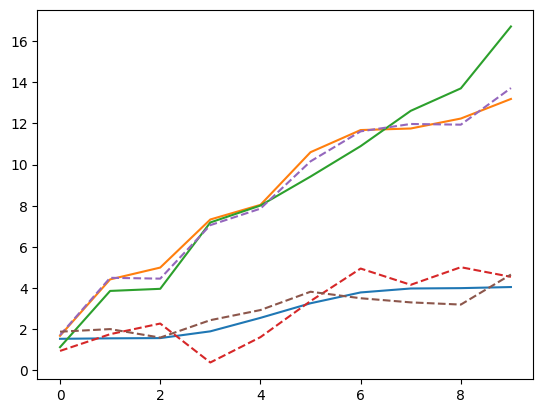

In [17]:
plt.plot(f_example)
plt.plot(f_est.T, "--")
plt.show()